# Problem

- Build a model of housing prices in California using the California census datah
- The data has metrics such as the population, median income, median housing price, and so on for each block group in California. Each row represents one district.
- Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.
- Model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.
- Model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.
- District housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district (excluding median housing prices), and they use complex rules to come up with an estimate. This is costly and time-consuming, and their estimates are not great; their typical error rate is about 15%.

## 1. Frame the problem
<br>
Predict housing prices - median house value.
<br>
Q: Is it supervised, unsupervised, or reinforcement learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques?
<br>
A: Supervised - Regression - Batch - Multivariate (many features)

## 2. Determine Performance Measure
<br>

- RMSE (Root Mean Square Error)

- MAE (Mean Absolute Error)
<br>
<br>
What other performance measures are out there?

## 3. Get and explore data

In [2]:
# get data

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()

In [3]:
# look at data

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# check completeness

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# possible values for categorical data

housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# ^ encode for higher value for near ocean?

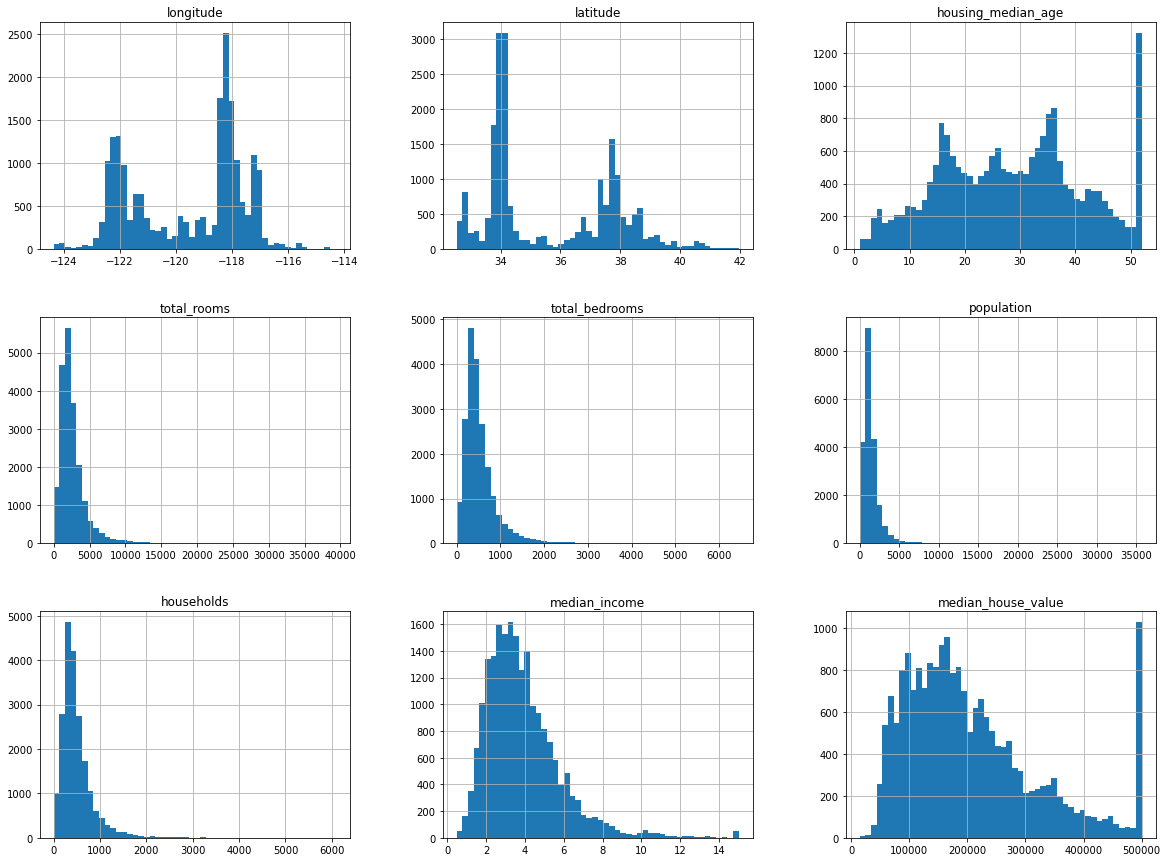

In [7]:
# histogram for numerical data

%matplotlib inline
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20,15)) 
plt.show()

- median income, median house value, housing median age -> capped
- median income is scaled
- features are on different scales
- distribution are mostly long tail

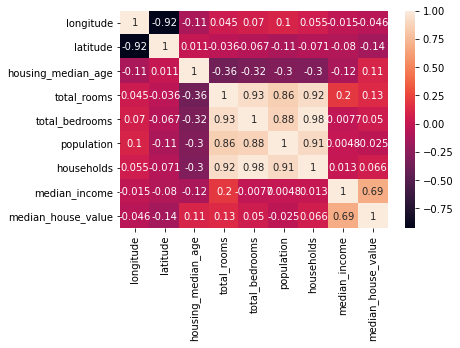

In [8]:
# correlation matrix for numerical data

import seaborn as sn

corrMatrix = housing.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## 4. Create test set

if dataset large enough:
- usually 20% of randomly select data 
- make sure that test set is static or else this will change every run: one solution is to separate it in the beginning or set random number generator seed (only works if dataset not updated)
- for datasets that update, set up a rule on the hash/identiier that always only gets 20% of dataset for testing
- random sampling is ok with large datasets otherwise you will introduce sampling bias

if dataset not large enough:
- ensure sample is representative of whole population >>> stratified sampling
- stratified sampling >>> population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population

- do stratified sampling on median income - look at histogram for distribution

In [11]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

In [14]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [29]:
print(len(strat_test_set), len(housing))

4128 20640


In [28]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

- remove income_cat so it wont get used in modelling

In [30]:
for set in (strat_train_set, strat_test_set): set.drop(["income_cat"], axis=1, inplace=True)

- geographical data

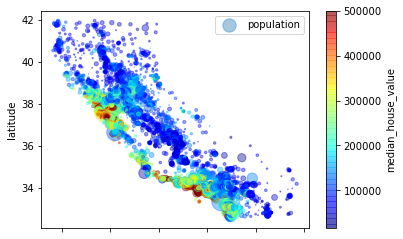

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
         s=housing["population"]/100, label="population",
         c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
     )
plt.legend()

- housing prices are very much related to the location (e.g., close to the ocean) and to the population density

## correlation

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

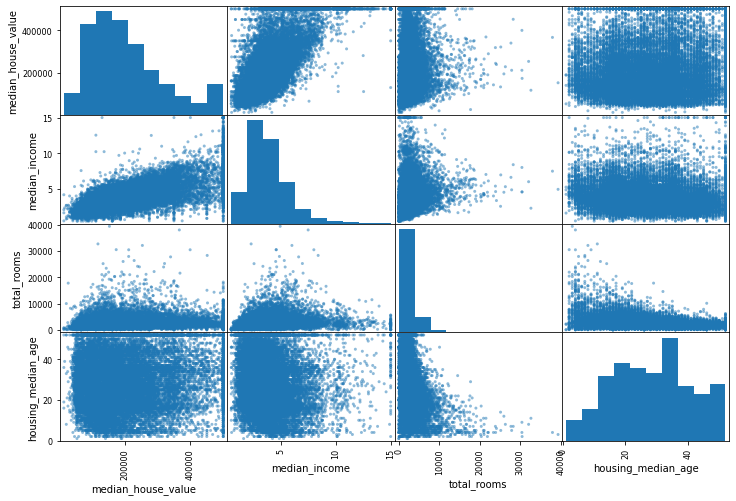

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [38]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

- You also noticed that some attributes have a tail-heavy distribution, so you may want to trans‐ form them (e.g., by computing their logarithm).

## Experimenting with Attribute Combinations

In [40]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [41]:
corr_matrix = housing.corr()

In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [43]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## data cleaning